In [1]:
# https://www.youtube.com/playlist?list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ

In [2]:
# from prev lessons

In [3]:
!wget https://raw.githubusercontent.com/karpathy/makemore/refs/heads/master/names.txt

--2025-01-20 16:45:19--  https://raw.githubusercontent.com/karpathy/makemore/refs/heads/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.004s  

2025-01-20 16:45:20 (59.3 MB/s) - ‘names.txt’ saved [228145/228145]



In [4]:
# NeuralNet
# recieve single char as input and return prob distrubition for next char

In [5]:
words = open("names.txt", "r").read().splitlines()

In [6]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [7]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [8]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [9]:
for x, y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

... --> y
..y --> u
.yu --> h
yuh --> e
uhe --> n
hen --> g
eng --> .
... --> d
..d --> i
.di --> o
dio --> n
ion --> d
ond --> r
ndr --> e
dre --> .
... --> x
..x --> a
.xa --> v
xav --> i
avi --> e


In [10]:
# Near copy paste of the layers we have developed in Part 3

# -----------------------------------------------------------------------------------------------
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

In [11]:
torch.manual_seed(42); # seed rng for reproducibility

In [12]:
# hierarchical network
n_embd = 24 # the dimensionality of the character embedding vectors
n_hidden = 128 # the number of neurons in the hidden layer of the ML

C = torch.randn((vocab_size, n_embd))
layers = [
    Linear(n_embd * block_size, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, vocab_size),
]

with torch.no_grad():
    layers[-1].weight *= 0.1

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

13603


In [13]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb]
  x = emb.view(emb.shape[0], -1)
  for layer in layers:
      x = layer(x)
  loss = F.cross_entropy(x, Yb)

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update: simple SGD
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.2994
  10000/ 200000: 2.2147
  20000/ 200000: 2.4812
  30000/ 200000: 2.0799
  40000/ 200000: 2.4012
  50000/ 200000: 2.0157
  60000/ 200000: 2.2780
  70000/ 200000: 2.3633
  80000/ 200000: 1.6726
  90000/ 200000: 1.7390
 100000/ 200000: 2.0401
 110000/ 200000: 1.9505
 120000/ 200000: 2.4090
 130000/ 200000: 2.2913
 140000/ 200000: 2.1732
 150000/ 200000: 2.2073
 160000/ 200000: 1.7185
 170000/ 200000: 2.2739
 180000/ 200000: 2.5392
 190000/ 200000: 1.9916


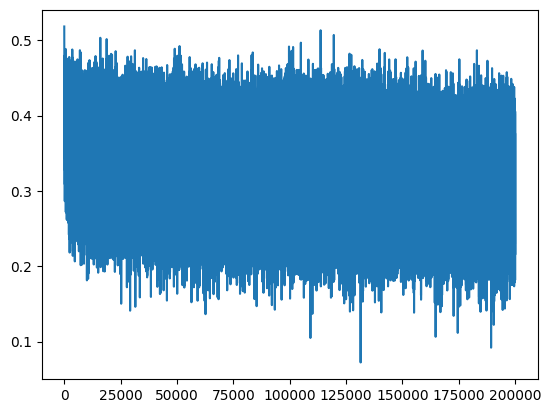

In [14]:
plt.plot(lossi)
# it looks ugly cause u can get lucky in any batch and get less loss, which makes this thick band
# to fix this take avg along the value

In [15]:
torch.tensor(lossi).view(-1, 1000).shape # reshape and take avg along the values

torch.Size([200, 1000])

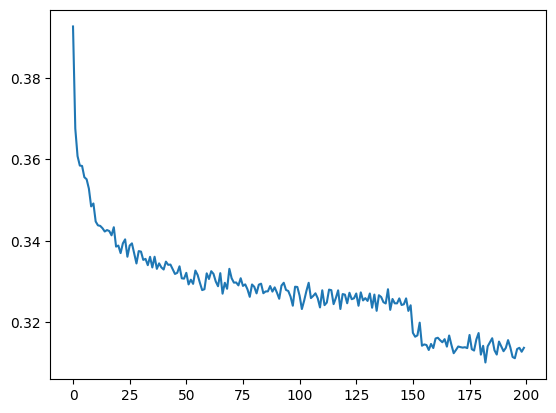

In [16]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [17]:
# put layer in eval mode for batchnorm especially
for layer in layers:
    layer.training = False

In [18]:
# create more layer types
class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, IX):
        self.out = self.weight[IX] # since it is going to select particular row if we do one hot embedding over it
        return self.out

    def parameters(self):
        return [self.weight]

class Flatten:
    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out

    def parameters(self):
        return []

class Sequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [19]:
# update to use new layers
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the ML

model = Sequential([
    Embedding(vocab_size, n_embd),
    Flatten(),
    Linear(n_embd * block_size, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, vocab_size),
])

with torch.no_grad():
    layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12097


In [20]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb)

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update: simple SGD
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.4033
  10000/ 200000: 2.3441
  20000/ 200000: 1.7557
  30000/ 200000: 1.8854
  40000/ 200000: 2.2454
  50000/ 200000: 2.0292
  60000/ 200000: 2.1982
  70000/ 200000: 2.2242
  80000/ 200000: 1.9808
  90000/ 200000: 2.1027
 100000/ 200000: 1.8591
 110000/ 200000: 2.0847
 120000/ 200000: 1.7408
 130000/ 200000: 2.5967
 140000/ 200000: 1.9910
 150000/ 200000: 2.2675
 160000/ 200000: 2.1280
 170000/ 200000: 1.8356
 180000/ 200000: 1.9261
 190000/ 200000: 1.9363


In [21]:
for layer in model.layers: # always do this after running mode;
    layer.training = False

In [22]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0566704273223877
val 2.102090358734131


In [23]:
# sample from the model
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

amen.
jia.
queena.
mai.
yas.
amia.
rion.
jayodes.
kaid.
ahamania.
leon.
janiya.
harionner.
kay.
ribl.
kyrah.
madhi.
caliana.
skell.
zaiana.


In [24]:
# problem we fuse all the chars to first layer too early

In [25]:
# build with more conext of 8 prev char input
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182580, 8]) torch.Size([182580])
torch.Size([22767, 8]) torch.Size([22767])
torch.Size([22799, 8]) torch.Size([22799])


In [26]:
for x, y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> e
.......e --> b
......eb --> r
.....ebr --> i
....ebri --> m
...ebrim --> a
..ebrima --> .
........ --> h
.......h --> i
......hi --> l
.....hil --> t
....hilt --> o
...hilto --> n
..hilton --> .
........ --> j
.......j --> h
......jh --> e
.....jhe --> n
....jhen --> e
...jhene --> .


In [27]:
# we will fuse 2 consuctive toger and return 4 output,by fusing 8 char
# then again fuse consectuives and go on
# so we concatenate
class FlattenConsecutive(): # join some consecutive elements and puts them in last dim
    def __init__(self, n):
        self.n = n # join n consecutive element and put them in last defination

    def __call__(self, x):
        B, T, C = x.shape # B is batch size, T is num of chars, C is embedding lenght per char
        x = x.view(B, T//self.n, C*self.n) # join n consecutive 
        if x.shape[1] == 1:
            x = x.squeeze()
        self.out = x
        return x

    def parameters(self):
        return []

In [28]:
# update to use new layers
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 68 # the number of neurons in the hidden layer of the ML

model = Sequential([
  Embedding(vocab_size, n_embd),
  FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
])

with torch.no_grad():
    layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

22397


In [29]:
ix = torch.randint(0, Xtr.shape[0], (4,)) # lets look at batch of 4 example
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  5, 12,  1, 14],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  1, 13],
        [ 0,  0,  0,  0,  0,  0,  0, 19]])

In [30]:
for layer in model.layers:
    print(layer.__class__.__name__, ":", tuple(layer.out.shape))  # output shape of each neural net n 

Embedding : (4, 8, 10)
FlattenConsecutive : (4, 4, 20)
Linear : (4, 4, 68)
BatchNorm1d : (4, 4, 68)
Tanh : (4, 4, 68)
FlattenConsecutive : (4, 2, 136)
Linear : (4, 2, 68)
BatchNorm1d : (4, 2, 68)
Tanh : (4, 2, 68)
FlattenConsecutive : (4, 136)
Linear : (4, 68)
BatchNorm1d : (4, 68)
Tanh : (4, 68)
Linear : (4, 27)


In [31]:
model.layers[3].out

tensor([[[-0.1694,  0.1178, -0.1337,  ...,  0.4409,  0.1098,  0.4420],
         [-0.1694,  0.1178, -0.1337,  ...,  0.4409,  0.1098,  0.4420],
         [-2.2441, -0.2046, -1.1741,  ..., -2.3745, -0.1413,  0.2404],
         [ 0.4188,  1.4303, -1.6364,  ..., -1.1407, -1.9651, -2.9147]],

        [[-0.1694,  0.1178, -0.1337,  ...,  0.4409,  0.1098,  0.4420],
         [-0.1694,  0.1178, -0.1337,  ...,  0.4409,  0.1098,  0.4420],
         [-0.1694,  0.1178, -0.1337,  ...,  0.4409,  0.1098,  0.4420],
         [-0.1694,  0.1178, -0.1337,  ...,  0.4409,  0.1098,  0.4420]],

        [[-0.1694,  0.1178, -0.1337,  ...,  0.4409,  0.1098,  0.4420],
         [-0.1694,  0.1178, -0.1337,  ...,  0.4409,  0.1098,  0.4420],
         [-0.1694,  0.1178, -0.1337,  ...,  0.4409,  0.1098,  0.4420],
         [ 0.9314, -3.4715,  2.9083,  ..., -2.3283,  2.7031, -0.7488]],

        [[-0.1694,  0.1178, -0.1337,  ...,  0.4409,  0.1098,  0.4420],
         [-0.1694,  0.1178, -0.1337,  ...,  0.4409,  0.1098,  0.4420],


In [32]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb)

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update: simple SGD
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.3704
  10000/ 200000: 2.3453
  20000/ 200000: 2.2389
  30000/ 200000: 2.0523
  40000/ 200000: 2.1543
  50000/ 200000: 2.2110
  60000/ 200000: 1.5241
  70000/ 200000: 2.1829
  80000/ 200000: 2.0562
  90000/ 200000: 2.2670
 100000/ 200000: 2.1351
 110000/ 200000: 2.0962
 120000/ 200000: 1.8466
 130000/ 200000: 2.0349
 140000/ 200000: 1.9427
 150000/ 200000: 1.7583
 160000/ 200000: 1.7789
 170000/ 200000: 2.3025
 180000/ 200000: 1.9344
 190000/ 200000: 2.3704


In [33]:
for layer in model.layers: # always do this after running mode;
    layer.training = False

In [34]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.9131056070327759
val 2.0206828117370605


In [35]:
# data explore
# explore data
# try search/filter/sort whatever u think
# outliers especially almost always uncover some bugs in data

# fix random seedP
# run simple baseline model
# make sure model compuation graph is fine
# run test over entire test instead of batches of test
# verify init loss is -log(1/n_classes) i.e. it predicts 1/n_classes prob for each class
# use xavier_normal initialization method
# keep init function outside of model
# init final layer correctly, decrease final layer weights if prob high by changing gain or adding numbers
# init well: final layer weights should be init correctly, when regressing final value mean is 50 init final bias to be 50
# you have an imbalanced dataset of a ratio 1:10 of positives:negatives, set the bias on your logits such that your network predicts probability of 0.1 at initialization
# settig it correcly will speed up convergance and eleminate hockey stick curve, where top few iter netowr is learning bias only
# set inputs to be 0, and neural net should perform worst
# overfit single batch, to do so increase param and they should align perfectly with label if not there is some bug
# debug: check activations for each layer and make sure they are not in saturaiton range
# check grad range for each layer and make sure they are not too small or too big grad or 0 grads too much
# and all layer should roughly have same grad hist plots

# does training loss decrease with increasing model param
# best place to visualize is just before y_hat = model(x)
# visualize model preductions for fixed test batch during course of training
# get model large enough to overfit then regularize it to underfit
# pick model: find most related paper and copy paste their simplest arch theat achives good enoguth perforamce

# use adam: or related thing used my paper
# if u have multiple signals to plut into your classifier plug one at a time, and everytime u should get performance boost
# dont use lr decay much
# regularize: get more data
# data augument
# use pretrain model
# stick to supervised
# reduce input dimensions
# small model size
# decrease batch size if u have batch norm
# add drop out
# increase weight decay
# early stopping
# first layer weights should get nice egdes and makes
# hyper param tuning: random over grid search
# basian hyper param tuning
# ensemeble
# 
# gradients are too small or too bug
# passed softmax to loss function that explect loss
# set model to eval mode
# reset grads
# make sure broadcast works fine
# broadcast if tensors have one dimension atleast
# and from right dim should be equal, one or not exist, if not exist then adds 1 there
# if one of operand has less dimension prepend one to left
# then for each dim result will be max of that dimension
# use resiudal connectoon when creating deep nn 
# non trainaiable model params
# sequential/ run in parallel

# understand dimension as one matrix inside other matrix
# one func that take dim num to operate as input like mean
# it will take mean for all other sub matrix inside that array along that dimension

e = torch.randn(1, 2, 4) 
print(e)

emean1 = e.mean(0)
print(emean1)

# channel dim is dimesnsion actually containing data
# make sure to have all the shape workotu before running training
# for sequense use (Batch, Timestep, Channel/data as input) -> change when computing error since loss functions expect cross entropy Channel as second dim
# logits = logits.view(B*T, C)
# targets = targets.view(B*T) cause cross entropy expet number
# dont transpose batch dim only transpose time and channel

# it helps to create multiple channel of communication
# like multi head attention

# do it with loop first
# then think how can we do it inside CUDA kernel
# using matrix mul or matrix operations

tensor([[[-0.5671, -1.3700, -2.0020,  1.1600],
         [ 0.3599,  1.4470,  1.0107,  2.2857]]])
tensor([[-0.5671, -1.3700, -2.0020,  1.1600],
        [ 0.3599,  1.4470,  1.0107,  2.2857]])
